# Imports

In [25]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import re
import os
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
from io import BytesIO

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = None

classifications = ["lcWestClassifications", "lcSouthClassifications", "lcEastClassifications", "lcNorthClassifications"]
url_entries = ["lcDownwardPhotoUrl", "lcEastPhotoUrl", "lcUpwardPhotoUrl", "lcNorthPhotoUrl", "lcSouthPhotoUrl", "lcWestPhotoUrl"]

# Downloading Data

In [30]:
# get app data
get_app_only = False

# mesausre att or site corrindates
get_site_coordinates = False

# dates
start_date = "2020-06-01"
end_date = "2020-07-01"

In [31]:
url = f"https://api.globe.gov/search/v1/measurement/protocol/measureddate/?protocols=land_covers&startdate={start_date}&enddate={end_date}&geojson=FALSE&sample=FALSE"
response = requests.get(url)
results = response.json()["results"]
df = pd.DataFrame(results)

def switch_coordinates():
    coordinates_df = df[df["lcMeasurementLatitude"].notnull()]
    coordinates_df = coordinates_df[df["lcMeasurementLongitude"].notnull()]

    coordinates_df["latitude"] = coordinates_df["lcMeasurementLatitude"].tolist()
    coordinates_df["longitude"] = coordinates_df["lcMeasurementLongitude"].tolist()
    return coordinates_df

def app_only():
    return df[df["lcDataSource"] == "GLOBE Observer App"]
    

#Expand the 'data' column by listing the contents and passing as a new dataframe
df = pd.concat([df, pd.DataFrame(list(df['data']))], axis=1)

#Drop the previously nested data column
df = df.drop('data', 1)

df.columns = [col_name.replace("landcovers", "lc") for col_name in df.columns]

# Initial Optional Cleaning scripts

if get_app_only:
    df = app_only()
if get_site_coordinates:
    df = switch_coordinates()

df

,protocol,measuredDate,createDate,updateDate,publishDate,organizationId,organizationName,siteId,siteName,countryName,countryCode,latitude,longitude,elevation,pid,lcDownwardPhotoUrl,lcEastExtraData,lcEastPhotoUrl,lcMucCode,lcUpwardPhotoUrl,lcEastCaption,lcWestClassifications,lcNorthCaption,lcNorthExtraData,lcDataSource,lcDryGround,lcSouthClassifications,lcWestCaption,lcNorthPhotoUrl,lcUpwardCaption,lcDownwardExtraData,lcEastClassifications,lcMucDetails,lcMeasuredAt,lcDownwardCaption,lcSouthPhotoUrl,lcMuddy,lcWestPhotoUrl,lcStandingWater,lcLeavesOnTrees,lcUserid,lcSouthExtraData,lcSouthCaption,lcRainingSnowing,lcUpwardExtraData,lcWestExtraData,lcLandCoverId,lcMucDescription,lcSnowIce,lcNorthClassifications,lcFieldNotes,lcMeasurementLatitude,lcMeasurementElevation,lcMeasurementLongitude
0,land_covers,2020-06-18,2020-06-18T19:10:02,2020-06-18T19:20:07,2020-11-04T21:31:17,233220,Al-Farouq Intermediate School at Jeddah,36397,Soil16-Heraa,Saudi Arabia,SAU,21.611502,39.138221,7.1,163694390,None,None,None,M91,None,None,None,None,None,GLOBE Data Entry Site Definition,None,None,None,None,None,None,None,None,2020-06-18T19:09:19.742489,None,None,None,None,None,None,NaN,None,None,None,None,None,32790,"Urban, Residential",None,None,None,NaN,NaN,NaN
1,land_covers,2020-06-18,2020-06-18T19:10:02,2020-06-18T19:20:07,2020-11-04T21:31:17,233220,Al-Farouq Intermediate School at Jeddah,36397,Soil16-Heraa,Saudi Arabia,SAU,21.611502,39.138221,7.1,163694390,None,None,None,M94,None,None,None,None,None,GLOBE Data Entry Site Definition,None,None,None,None,None,None,None,None,2020-06-18T19:19:16.966165,None,None,None,None,None,None,NaN,None,None,None,None,None,32791,"Urban, Other",None,None,urban land cover,NaN,NaN,NaN
2,land_covers,2020-06-27,2020-06-27T22:10:04,2020-06-29T12:55:05,2020-11-04T21:31:17,17043304,United States of America Citizen Science,36886,13TDE799294,None,None,40.014562,-105.235524,1596.6,163731596,https://data.globe.gov/system/photos/2020/06/2...,"(source: app, (compassData.horizon: 3.16781977...",https://data.globe.gov/system/photos/2020/06/2...,None,https://data.globe.gov/system/photos/2020/06/2...,,None,,"(source: app, (compassData.horizon: 1.71871610...",GLOBE Observer App,True,None,,https://data.globe.gov/system/photos/2020/06/2...,,"(source: app, (compassData.horizon: -88.413938...",None,,2020-06-27T21:14:00,,https://data.globe.gov/system/photos/2020/06/2...,True,https://data.globe.gov/system/photos/2020/06/2...,False,True,67185765.0,"(source: app, (compassData.horizon: 1.31475974...",,False,"(source: app, (compassData.horizon: 88.1844509...","(source: app, (compassData.horizon: 3.89128138...",33839,None,False,None,Muddy conditions.,40.0147,1597.1,-105.2350
3,land_covers,2020-06-27,2020-06-27T22:10:04,2020-06-29T12:55:09,2020-11-04T21:31:17,17043304,United States of America Citizen Science,41556,13TDE779300,None,None,40.019918,-105.258979,1612.4,163731594,https://data.globe.gov/system/photos/2020/06/2...,"(source: app, (compassData.horizon: 0.44272542...",https://data.globe.gov/system/photos/2020/06/2...,None,https://data.globe.gov/system/photos/2020/06/2...,,None,,"(source: app, (compassData.horizon: -0.5178247...",GLOBE Observer App,True,None,,https://data.globe.gov/system/photos/2020/06/2...,,"(source: app, (compassData.horizon: -86.357510...",None,,2020-06-27T21:00:00,,https://data.globe.gov/system/photos/2020/06/2...,False,https://data.globe.gov/system/photos/2020/06/2...,False,True,67185765.0,"(source: app, (compassData.horizon: 0.82118162...",,False,"(source: app, (compassData.horizon: 88.6074287...","(source: app, (compassData.horizon: 6.78667252...",33834,None,False,None,No mosquito habitat. However pavement has crac...,40.0200,1610.8,-105.2585
4,land_covers,2020-06-28,2020-06-28T23:50:02,2020-06-28T23:50:02,2020-11-04T21:31:17,23132865,Officers Residece Intermediate Girls School at...,50962,Officers Residece Intermediate Girls School at...,Saudi Arabia,SAU,24.229192,40.969218,1651.8,163735788,None,None,None,M81,None,None

# Convert To Local Times

In [7]:
def convert_times(date, longitude):
    # Adapted from Matt Bandel's Mosquito Habitat Mapper Notebook
    # convert the date string to date object and normalize based on partitioning
    date_obj = datetime.strptime(re.sub(r"\..*", "", date), "%Y-%m-%dT%H:%M:%S")
    # convert the date string to date object and correct for longitude
    zone = int(round(longitude * 24 / 360, 0))
    converted = date_obj + timedelta(hours=zone)
    tt = converted.timetuple()
    
    return tt.tm_year, tt.tm_mon, tt.tm_mday, tt.tm_yday
vectorized_convert = np.vectorize(convert_times)

df["year"], df["month"], df["day"], df["day of year"] = vectorized_convert(df['lcMeasuredAt'].to_numpy(), df['longitude'].to_numpy())
df

,protocol,measuredDate,createDate,updateDate,publishDate,organizationId,organizationName,siteId,siteName,countryName,...,lcSnowIce,lcNorthClassifications,lcFieldNotes,lcMeasurementLatitude,lcMeasurementElevation,lcMeasurementLongitude,year,month,day,day of year
0,land_covers,2020-06-01,2020-06-01T05:12:14,2020-10-26T06:36:26,2020-10-26T21:48:19,61563928,Sankalp Senior Secondary Day Boarding High School,176039,SANKALP SENIOR SECONDARY SCHOOL,India,...,None,None,None,NaN,NaN,NaN,2020,6,1,153
1,land_covers,2020-06-01,2020-06-01T19:05:02,2020-06-03T16:15:20,2020-10-26T21:48:19,17501721,United Kingdom Citizen Science,183432,30UXE599220,None,...,False,None,Temperature 22 degrees light breeze from north...,53.4230,66.7,-0.5935,2020,6,1,153
2,land_covers,2020-06-01,2020-06-01T03:55:02,2020-06-01T16:45:18,2020-10-26T21:48:19,17043304,United States of America Citizen Science,200647,10SEG926564,None,...,False,None,This park was renovated about 3 years ago. The...,37.5501,19.4,-121.9514,2020,5,31,152
3,land_covers,2020-06-01,2020-06-01T00:50:02,2020-06-05T15:40:05,2020-10-26T21:48:19,17043304,United States of America Citizen Science,200750,10SEF856901,None,...,False,None,There is a walking trail throughout this land....,36.9532,8.3,-122.0375,2020,5,31,152
4,land_covers,2020-06-01,2020-06-01T01:20:05,2020-06-01T16:45:03,2020-10-26T21:48:19,17043304,United States of America Citizen Science,200755,11SMS725566,None,...,False,None,(none),33.0483,13.2,-117.2941,2020,5,31,152
5,land_covers,2020-06-01,2020-06-01T18:40:04,2020-06-03T16:15:15,2020-10-26T21:48:19,17043304,United States of America Citizen Science,200825,10SDJ319525,None,...,False,None,"This area was previously logged, it appears to...",39.3199,106.0,-123.7900,2020,6,1,153
6,land_covers,2020-06-01,2020-06-01T19:15:02,2020-06-03T16:20:30,2020-10-26T21:48:19,17043304,United States of America Citizen Science,200835,11SLT730500,None,...,False,"20% MUC 91 [Urban, Residential Property]; 30% ...",(none),33.8830,24.7,-118.3724,2020,6,1,153
7,land_covers,2020-06-01,2020-06-01T19:15:03,2020-06-03T16:15:11,2020-10-26T21:48:19,17043304,United States of America Citizen Science,200839,10SEG660781,None,...,False,"70% MUC 63 [Wetlands, In Salt/Brackish Tidal (...",(none),37.7479,3.6,-122.2508,2020,6,1,153
8,land_covers,2020-06-01,2020-06-01T20:05:02,2020-06-03T16:20:36,2020-10-26T21:48:19,17043304,United States of America Citizen Science,200855,11SMT773664,None,...,False,None,This area is a designated park,34.0384,414.2,-117.2451,2020,6,1,153
9,land_covers,2020-06-01,2020-06-01T22:15:02,2020-06-03T16:20:14,2020-10-26T21:48:19,17043304,United States of America Citizen Science,200887,10SEF849927,None,...,False,"40% MUC 91 [Urban, Residential Property]; 50% ...","66 degrees F, with a high of 69 today. Breezy/...",36.9770,79.7,-122.0459,2020,6,1,153


# Image Resolution, Size, and Score 

In [7]:

def get_resolution(df):
    # adding in columns into DataFrame
    for entry in url_entries:
        df[entry.replace("Url", "Rez")] = np.nan
        df[entry.replace("Url", "Size")] = np.nan
        df[entry.replace("Url", "ContentScore")] = np.nan
    
    # helper function
    def get_entry_resolution(row):
        
        for entry in url_entries:
            try:
                if row[entry] and "https" in row[entry]:
                    response = requests.get(row[entry], stream=True)
                    resolution = Image.open(BytesIO(response.content)).size 
                    size = len(response.content)
                
                    row[entry.replace("Url", "Rez")] = resolution
                    row[entry.replace("Url", "Size")] = size / 1000000 # convert to megabytes
                    row[entry.replace("Url", "ContentScore")] = size / (resolution[0] * resolution[1]) # bytes / pixel
            except Exception as e:
                print(f"{row[entry]} failed: {repr(e)}")
        return row
        
    return df.apply(get_entry_resolution, axis=1)


#df["DownRez"], df["EastRez"], df["UpRez"], df["NorthRez"], df["SouthRez"], df["WestRez"] = vectorized_rez(df['lcDownwardPhotoUrl'].to_numpy(), df['lcDownwardPhotoUrl'].to_numpy(), df['lcEastPhotoUrl'].to_numpy(), df['lcUpwardPhotoUrl'].to_numpy(), df['lcNorthPhotoUrl'].to_numpy(), df['lcSouthPhotoUrl'].to_numpy(), df['lcWestPhotoUrl'].to_numpy())

In [8]:
%time df = get_resolution(df)

Wall time: 4min 48s


# Download Photos

In [24]:
if not os.path.exists("Images"):
    os.makedirs("Images")
    
    
option = "1080p"
def download_photo(row):
    
    # 3 different helper functions
    
    # resize image based to 1080p
    def resize(img, info):
        img.resize((1920, 1080)).save(f"Images/{info}.jpg")
    
    # add data overlay
    def overlay(img, info):
        draw = ImageDraw.Draw(img)
        draw.line([(0,img.size[1]), (img.size[0], img.size[1])], width = 200, fill="#FFFFFF")
        fnt = ImageFont.truetype("arial.ttf", 40)
        draw.text((0,img.size[1] - 100), info, font = fnt, fill = "#000000", align = "right")
        img.save(f"Images/{re.search(r'.*(?=-[a-zA-Z]*-)', info).group(0)}.jpg")
        
    # save original image
    def original(img, info):
        img.save(f"Images/{info}.jpg")
    
    # download image scripts
    def get_img(url):
        try:
            return Image.open(requests.get(url, stream=True).raw)
        except Exception as e:
            print(f"{url} failed: {repr(e)}")
            return None
    def download_photo(url, direction, siteid, date, muc):
        photo_id = re.search(r'(?<=\d\d\d\d\/\d\d\/\d\d\/).*(?=\/)', url).group(0)
        img_info = f"{photo_id}-{direction}-{siteid}-{date}-{muc}"
        
        img = get_img(url)
        
        
        options = {"original" : original, "1080p": resize, "overlay": overlay}
        options[option](img, img_info)
    
    
    for entry in url_entries:
        download_photo(row[entry], entry.replace("lc", "").replace("Url", ""), row["siteId"], row["measuredDate"], row['lcMucCode'])
       

In [19]:
df.apply(download_photo, axis=1)

,protocol,measuredDate,createDate,updateDate,publishDate,organizationId,organizationName,siteId,siteName,countryName,...,lcSnowIce,lcNorthClassifications,lcFieldNotes,lcMeasurementLatitude,lcMeasurementElevation,lcMeasurementLongitude,year,month,day,day of year
0,land_covers,2020-06-01,2020-06-01T05:12:14,2020-10-26T06:36:26,2020-10-26T21:48:19,61563928,Sankalp Senior Secondary Day Boarding High School,176039,SANKALP SENIOR SECONDARY SCHOOL,India,...,None,None,None,NaN,NaN,NaN,2020,6,1,153
1,land_covers,2020-06-01,2020-06-01T19:05:02,2020-06-03T16:15:20,2020-10-26T21:48:19,17501721,United Kingdom Citizen Science,183432,30UXE599220,None,...,False,None,Temperature 22 degrees light breeze from north...,53.4230,66.7,-0.5935,2020,6,1,153
2,land_covers,2020-06-01,2020-06-01T03:55:02,2020-06-01T16:45:18,2020-10-26T21:48:19,17043304,United States of America Citizen Science,200647,10SEG926564,None,...,False,None,This park was renovated about 3 years ago. The...,37.5501,19.4,-121.9514,2020,5,31,152
3,land_covers,2020-06-01,2020-06-01T00:50:02,2020-06-05T15:40:05,2020-10-26T21:48:19,17043304,United States of America Citizen Science,200750,10SEF856901,None,...,False,None,There is a walking trail throughout this land....,36.9532,8.3,-122.0375,2020,5,31,152
4,land_covers,2020-06-01,2020-06-01T01:20:05,2020-06-01T16:45:03,2020-10-26T21:48:19,17043304,United States of America Citizen Science,200755,11SMS725566,None,...,False,None,(none),33.0483,13.2,-117.2941,2020,5,31,152
5,land_covers,2020-06-01,2020-06-01T18:40:04,2020-06-03T16:15:15,2020-10-26T21:48:19,17043304,United States of America Citizen Science,200825,10SDJ319525,None,...,False,None,"This area was previously logged, it appears to...",39.3199,106.0,-123.7900,2020,6,1,153
6,land_covers,2020-06-01,2020-06-01T19:15:02,2020-06-03T16:20:30,2020-10-26T21:48:19,17043304,United States of America Citizen Science,200835,11SLT730500,None,...,False,"20% MUC 91 [Urban, Residential Property]; 30% ...",(none),33.8830,24.7,-118.3724,2020,6,1,153
7,land_covers,2020-06-01,2020-06-01T19:15:03,2020-06-03T16:15:11,2020-10-26T21:48:19,17043304,United States of America Citizen Science,200839,10SEG660781,None,...,False,"70% MUC 63 [Wetlands, In Salt/Brackish Tidal (...",(none),37.7479,3.6,-122.2508,2020,6,1,153
8,land_covers,2020-06-01,2020-06-01T20:05:02,2020-06-03T16:20:36,2020-10-26T21:48:19,17043304,United States of America Citizen Science,200855,11SMT773664,None,...,False,None,This area is a designated park,34.0384,414.2,-117.2451,2020,6,1,153
9,land_covers,2020-06-01,2020-06-01T22:15:02,2020-06-03T16:20:14,2020-10-26T21:48:19,17043304,United States of America Citizen Science,200887,10SEF849927,None,...,False,"40% MUC 91 [Urban, Residential Property]; 50% ...","66 degrees F, with a high of 69 today. Breezy/...",36.9770,79.7,-122.0459,2020,6,1,153


# Plot Count over time

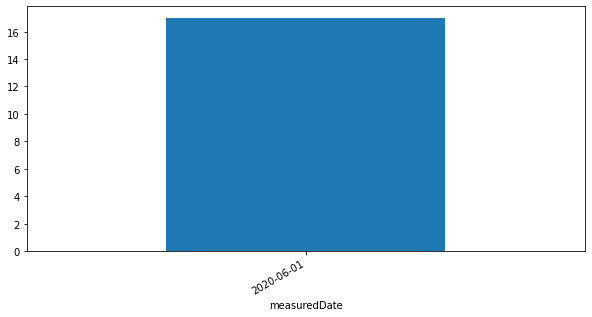

In [5]:
time_series = df.groupby("measuredDate").size()

fig = plt.figure(figsize = (10, 5))
time_series.plot.bar()
fig.autofmt_xdate()

# Classifications analysis (Work in Progress)

In [101]:

test_row = df.loc[6]

In [53]:
test_row[classifications].tolist()

['30% MUC 91 [Urban, Residential Property]; 10% MUC 12 (b) [Trees, Loosely Spaced, Deciduous - Broad Leaved]; 60% MUC 43 [Herbaceous/Grassland, Short Grass]',
 '30% MUC 91 [Urban, Residential Property]; 10% MUC 12 (b) [Trees, Loosely Spaced, Deciduous - Broad Leaved]; 60% MUC 43 [Herbaceous/Grassland, Short Grass]',
 '20% MUC 91 [Urban, Residential Property]; 30% MUC 12 (b) [Trees, Loosely Spaced, Deciduous - Broad Leaved]; 50% MUC 43 [Herbaceous/Grassland, Short Grass]',
 '20% MUC 91 [Urban, Residential Property]; 30% MUC 12 (b) [Trees, Loosely Spaced, Deciduous - Broad Leaved]; 50% MUC 43 [Herbaceous/Grassland, Short Grass]']

In [54]:

classification_list = [re.sub(r" *\d{0,3}% ", "", obj) for sublist in test_row[classifications].tolist() for obj in sublist.split(";")]


In [55]:
classification_list

['MUC 91 [Urban, Residential Property]',
 'MUC 12 (b) [Trees, Loosely Spaced, Deciduous - Broad Leaved]',
 'MUC 43 [Herbaceous/Grassland, Short Grass]',
 'MUC 91 [Urban, Residential Property]',
 'MUC 12 (b) [Trees, Loosely Spaced, Deciduous - Broad Leaved]',
 'MUC 43 [Herbaceous/Grassland, Short Grass]',
 'MUC 91 [Urban, Residential Property]',
 'MUC 12 (b) [Trees, Loosely Spaced, Deciduous - Broad Leaved]',
 'MUC 43 [Herbaceous/Grassland, Short Grass]',
 'MUC 91 [Urban, Residential Property]',
 'MUC 12 (b) [Trees, Loosely Spaced, Deciduous - Broad Leaved]',
 'MUC 43 [Herbaceous/Grassland, Short Grass]']

In [56]:
list(dict.fromkeys(classification_list))

['MUC 91 [Urban, Residential Property]',
 'MUC 12 (b) [Trees, Loosely Spaced, Deciduous - Broad Leaved]',
 'MUC 43 [Herbaceous/Grassland, Short Grass]']

# Identify Repeats

In [20]:
# same day, or over date range
same_day = True
if same_day:
    suspect_repeats = df.groupby(by = ["measuredDate", "lcMeasurementLatitude", "lcMeasurementLongitude"]).filter(lambda x: len(x) > 1)
else:
    suspect_repeats = df.groupby(by = ["lcMeasurementLatitude", "lcMeasurementLongitude"]).filter(lambda x: len(x) > 1)
    
suspect_repeats

,protocol,measuredDate,createDate,updateDate,publishDate,organizationId,organizationName,siteId,siteName,countryName,countryCode,latitude,longitude,elevation,pid,lcDownwardPhotoUrl,lcEastExtraData,lcEastPhotoUrl,lcMucCode,lcUpwardPhotoUrl,lcEastCaption,lcWestClassifications,lcNorthCaption,lcNorthExtraData,lcDataSource,lcDryGround,lcSouthClassifications,lcWestCaption,lcNorthPhotoUrl,lcUpwardCaption,lcDownwardExtraData,lcEastClassifications,lcMucDetails,lcMeasuredAt,lcDownwardCaption,lcSouthPhotoUrl,lcMuddy,lcWestPhotoUrl,lcStandingWater,lcLeavesOnTrees,lcUserid,lcSouthExtraData,lcSouthCaption,lcRainingSnowing,lcUpwardExtraData,lcWestExtraData,lcLandCoverId,lcMucDescription,lcSnowIce,lcNorthClassifications,lcFieldNotes,lcMeasurementLatitude,lcMeasurementElevation,lcMeasurementLongitude
262,land_covers,2020-06-17,2020-06-17T14:30:03,2020-06-17T15:55:46,2020-11-04T21:31:17,17043304,United States of America Citizen Science,201860,14RPU126672,None,None,30.431642,-97.827460,284.2,163688902,https://data.globe.gov/system/photos/2020/06/1...,"(source: app, (compassData.horizon: -40.655380...",https://data.globe.gov/system/photos/2020/06/1...,None,https://data.globe.gov/system/photos/2020/06/1...,,None,,"(source: app, (compassData.horizon: -18.551572...",GLOBE Observer App,False,None,,https://data.globe.gov/system/photos/2020/06/1...,,"(source: app, (compassData.horizon: -88.170425...",None,,2020-06-17T14:26:00,,https://data.globe.gov/system/photos/2020/06/1...,False,https://data.globe.gov/system/photos/2020/06/1...,False,True,67227647.0,"(source: app, (compassData.horizon: -51.515313...",,False,"(source: app, (compassData.horizon: -68.515074...","(source: app, (compassData.horizon: -28.042100...",32722,None,False,None,(none),30.4323,285.0,-97.8268
264,land_covers,2020-06-17,2020-06-17T14:30:03,2020-06-17T15:55:46,2020-11-04T21:31:17,17043304,United States of America Citizen Science,201860,14RPU126672,None,None,30.431642,-97.827460,284.2,163688902,https://data.globe.gov/system/photos/2020/06/1...,"(source: app, (compassData.horizon: -34.603711...",https://data.globe.gov/system/photos/2020/06/1...,None,https://data.globe.gov/system/photos/2020/06/1...,,None,,"(source: app, (compassData.horizon: -15.866070...",GLOBE Observer App,False,None,,https://data.globe.gov/system/photos/2020/06/1...,,"(source: app, (compassData.horizon: -89.605428...",None,,2020-06-17T14:24:00,,https://data.globe.gov/system/photos/2020/06/1...,False,https://data.globe.gov/system/photos/2020/06/1...,False,True,67227647.0,"(source: app, (compassData.horizon: -34.740328...",,False,"(source: app, (compassData.horizon: 88.5682613...","(source: app, (compassData.horizon: -14.912261...",32721,None,False,None,(none),30.4323,285.0,-97.8268
348,land_covers,2020-06-10,2020-06-10T23:40:02,2020-06-12T18:00:10,2020-11-04T21:31:17,17615655,Thailand Citizen Science,202219,47QPU433745,None,None,16.949869,100.345797,52.0,163662707,https://data.globe.gov/system/photos/2020/06/1...,(source: camera),https://data.globe.gov/system/photos/2020/06/1...,None,https://data.globe.gov/system/photos/2020/06/1...,,None,,(source: camera),GLOBE Observer App,True,None,,https://data.globe.gov/system/photos/2020/06/1...,,(source: camera),None,,2020-06-10T23:34:00,,https://data.globe.gov/system/photos/2020/06/1...,False,https://data.globe.gov/system/photos/2020/06/1...,False,True,67277767.0,(source: camera),,False,(source: camera),(source: camera),31928,None,False,None,(none),16.9502,52.5,100.3464
349,land_covers,2020-06-10,2020-06-10T23:40:02,2020-06-12T18:00:10,2020-11-04T21:31:17,17615655,Thailand Citizen Science,202219,47QPU433745,None,None,16.949869,100.345797,52.0,163662707,https://data.globe.gov/system/photos/2020/06/1...,(source: camera),https://data.globe.gov/system/photos/2020/06/1...,None,https://data.globe.gov/system/photos/2020/06/1...,,None,,(source: camera),GLOBE Observer App,True,None,,https://data.globe.gov/system/photos/2020/06/1...,,(source: camera),None,,2020-06-10T23:38:00,,https://

# Preview Each row of Data

In [15]:
rows = df.index.tolist()

def view_row(row = 0):
    display(df.loc[row].to_frame())
    
interactive(view_row, row = rows)

interactive(children=(Dropdown(description='row', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

# Get Decimal Precision

In [ ]:
def get_precision(latitude, longitude):
    y_decimal = 0
    x_decimal = 0
    try:
        y_decimal = len(str(latitude).split(".")[1])
    except IndexError:
        pass
    try:
        x_decimal = len(str(longitude).split(".")[1])
    except IndexError:
        pass
    
    return x_decimal, y_decimal

vectorized_precision = np.vectorize(get_precision)

df["x_decimal"], df["y_decimal"] = vectorized_precision(df["lcMeasurementLatitude"].to_numpy(), df["lcMeasurementLongitude"].to_numpy())

# Count Valid 

In [ ]:
def count_valid(identifier, *args):

    count = 0 
    for url in args:
        if url and identifier in url:
            count += 1
    return count


vectorize_count = np.vectorize(count_valid)
df["photo_count"] = vectorize_count(
    "http",
    df["lcDownwardPhotoUrl"].to_numpy(),
    df["lcUpwardPhotoUrl"].to_numpy(),
    df["lcEastPhotoUrl"].to_numpy(),
    df["lcNorthPhotoUrl"].to_numpy(),
    df["lcSouthPhotoUrl"].to_numpy(),
    df["lcWestPhotoUrl"].to_numpy(),
)

df["classification_count"] = vectorize_count(
    "%",
    df["lcEastClassifications"].to_numpy(),
    df["lcNorthClassifications"].to_numpy(),
    df["lcSouthClassifications"].to_numpy(),
    df["lcWestClassifications"].to_numpy(),
)


# Download Data as CSV

In [41]:
get_raw = False

def images(url):
    return url != None
def classification_filter(classification):
    return classification != None

vectorized_photo_filter = np.vectorize(images)
vectorized_classification = np.vectorize(classification_filter)
if not get_raw:
    # only gets data that has all 6 images or north image
    six_photos = np.all(vectorized_photo_filter(df[url_entries].to_numpy()), axis = 1)
    north_photos = vectorized_photo_filter(df[url_entries[3]].to_numpy())
    good_photo_data = np.logical_or(six_photos, north_photos)
    
    # data that has all classifications
    good_classification = np.all(vectorized_classification(df[classifications].to_numpy()), axis = 1)
    good_data = np.logical_and(good_photo_data, good_classification)
    df[good_data].to_csv("Data.csv")
else:
    df.to_csv("Data.csv")

In [33]:
df

,protocol,measuredDate,createDate,updateDate,publishDate,organizationId,organizationName,siteId,siteName,countryName,countryCode,latitude,longitude,elevation,pid,lcDownwardPhotoUrl,lcEastExtraData,lcEastPhotoUrl,lcMucCode,lcUpwardPhotoUrl,lcEastCaption,lcWestClassifications,lcNorthCaption,lcNorthExtraData,lcDataSource,lcDryGround,lcSouthClassifications,lcWestCaption,lcNorthPhotoUrl,lcUpwardCaption,lcDownwardExtraData,lcEastClassifications,lcMucDetails,lcMeasuredAt,lcDownwardCaption,lcSouthPhotoUrl,lcMuddy,lcWestPhotoUrl,lcStandingWater,lcLeavesOnTrees,lcUserid,lcSouthExtraData,lcSouthCaption,lcRainingSnowing,lcUpwardExtraData,lcWestExtraData,lcLandCoverId,lcMucDescription,lcSnowIce,lcNorthClassifications,lcFieldNotes,lcMeasurementLatitude,lcMeasurementElevation,lcMeasurementLongitude
0,land_covers,2020-06-18,2020-06-18T19:10:02,2020-06-18T19:20:07,2020-11-04T21:31:17,233220,Al-Farouq Intermediate School at Jeddah,36397,Soil16-Heraa,Saudi Arabia,SAU,21.611502,39.138221,7.1,163694390,None,None,None,M91,None,None,None,None,None,GLOBE Data Entry Site Definition,None,None,None,None,None,None,None,None,2020-06-18T19:09:19.742489,None,None,None,None,None,None,NaN,None,None,None,None,None,32790,"Urban, Residential",None,None,None,NaN,NaN,NaN
1,land_covers,2020-06-18,2020-06-18T19:10:02,2020-06-18T19:20:07,2020-11-04T21:31:17,233220,Al-Farouq Intermediate School at Jeddah,36397,Soil16-Heraa,Saudi Arabia,SAU,21.611502,39.138221,7.1,163694390,None,None,None,M94,None,None,None,None,None,GLOBE Data Entry Site Definition,None,None,None,None,None,None,None,None,2020-06-18T19:19:16.966165,None,None,None,None,None,None,NaN,None,None,None,None,None,32791,"Urban, Other",None,None,urban land cover,NaN,NaN,NaN
2,land_covers,2020-06-27,2020-06-27T22:10:04,2020-06-29T12:55:05,2020-11-04T21:31:17,17043304,United States of America Citizen Science,36886,13TDE799294,None,None,40.014562,-105.235524,1596.6,163731596,https://data.globe.gov/system/photos/2020/06/2...,"(source: app, (compassData.horizon: 3.16781977...",https://data.globe.gov/system/photos/2020/06/2...,None,https://data.globe.gov/system/photos/2020/06/2...,,None,,"(source: app, (compassData.horizon: 1.71871610...",GLOBE Observer App,True,None,,https://data.globe.gov/system/photos/2020/06/2...,,"(source: app, (compassData.horizon: -88.413938...",None,,2020-06-27T21:14:00,,https://data.globe.gov/system/photos/2020/06/2...,True,https://data.globe.gov/system/photos/2020/06/2...,False,True,67185765.0,"(source: app, (compassData.horizon: 1.31475974...",,False,"(source: app, (compassData.horizon: 88.1844509...","(source: app, (compassData.horizon: 3.89128138...",33839,None,False,None,Muddy conditions.,40.0147,1597.1,-105.2350
3,land_covers,2020-06-27,2020-06-27T22:10:04,2020-06-29T12:55:09,2020-11-04T21:31:17,17043304,United States of America Citizen Science,41556,13TDE779300,None,None,40.019918,-105.258979,1612.4,163731594,https://data.globe.gov/system/photos/2020/06/2...,"(source: app, (compassData.horizon: 0.44272542...",https://data.globe.gov/system/photos/2020/06/2...,None,https://data.globe.gov/system/photos/2020/06/2...,,None,,"(source: app, (compassData.horizon: -0.5178247...",GLOBE Observer App,True,None,,https://data.globe.gov/system/photos/2020/06/2...,,"(source: app, (compassData.horizon: -86.357510...",None,,2020-06-27T21:00:00,,https://data.globe.gov/system/photos/2020/06/2...,False,https://data.globe.gov/system/photos/2020/06/2...,False,True,67185765.0,"(source: app, (compassData.horizon: 0.82118162...",,False,"(source: app, (compassData.horizon: 88.6074287...","(source: app, (compassData.horizon: 6.78667252...",33834,None,False,None,No mosquito habitat. However pavement has crac...,40.0200,1610.8,-105.2585
4,land_covers,2020-06-28,2020-06-28T23:50:02,2020-06-28T23:50:02,2020-11-04T21:31:17,23132865,Officers Residece Intermediate Girls School at...,50962,Officers Residece Intermediate Girls School at...,Saudi Arabia,SAU,24.229192,40.969218,1651.8,163735788,None,None,None,M81,None,None

In [42]:
df[good_data]

,protocol,measuredDate,createDate,updateDate,publishDate,organizationId,organizationName,siteId,siteName,countryName,countryCode,latitude,longitude,elevation,pid,lcDownwardPhotoUrl,lcEastExtraData,lcEastPhotoUrl,lcMucCode,lcUpwardPhotoUrl,lcEastCaption,lcWestClassifications,lcNorthCaption,lcNorthExtraData,lcDataSource,lcDryGround,lcSouthClassifications,lcWestCaption,lcNorthPhotoUrl,lcUpwardCaption,lcDownwardExtraData,lcEastClassifications,lcMucDetails,lcMeasuredAt,lcDownwardCaption,lcSouthPhotoUrl,lcMuddy,lcWestPhotoUrl,lcStandingWater,lcLeavesOnTrees,lcUserid,lcSouthExtraData,lcSouthCaption,lcRainingSnowing,lcUpwardExtraData,lcWestExtraData,lcLandCoverId,lcMucDescription,lcSnowIce,lcNorthClassifications,lcFieldNotes,lcMeasurementLatitude,lcMeasurementElevation,lcMeasurementLongitude
9,land_covers,2020-06-02,2020-06-02T12:55:02,2020-06-02T16:35:02,2020-11-04T21:31:17,393599,Bowling Green State University (USOHP793),51241,17TKG811058,United States,USA,41.573917,-83.625603,192.1,163629653,https://data.globe.gov/system/photos/2020/06/0...,"(source: app, (compassData.horizon: 25.3517639...",https://data.globe.gov/system/photos/2020/06/0...,M91,https://data.globe.gov/system/photos/2020/06/0...,,"10% MUC 11 (n) [Trees, Loosely Spaced, Evergre...",,"(source: app, (compassData.horizon: 24.8977747...",GLOBE Observer App,True,"10% MUC 11 (n) [Trees, Loosely Spaced, Evergre...",,https://data.globe.gov/system/photos/2020/06/0...,,"(source: app, (compassData.horizon: -89.589040...","10% MUC 11 (n) [Trees, Loosely Spaced, Evergre...",,2020-06-02T12:51:00,,https://data.globe.gov/system/photos/2020/06/0...,False,https://data.globe.gov/system/photos/2020/06/0...,False,True,398545.0,"(source: app, (compassData.horizon: 22.2352618...",,False,"(source: app, (compassData.horizon: 88.2102040...","(source: app, (compassData.horizon: 18.4345259...",31736,"Urban, Residential Property",False,"10% MUC 11 (n) [Trees, Loosely Spaced, Evergre...",(none),41.5747,191.9,-83.6250
10,land_covers,2020-06-09,2020-06-09T18:15:03,2020-06-12T14:05:03,2020-11-04T21:31:17,17043304,United States of America Citizen Science,52369,16SEJ191373,None,None,39.184731,-86.778849,231.0,163656702,https://data.globe.gov/system/photos/2020/06/0...,"(source: app, (compassData.horizon: 11.1863002...",https://data.globe.gov/system/photos/2020/06/0...,M43,https://data.globe.gov/system/photos/2020/06/0...,,"10% MUC 11 (n) [Trees, Loosely Spaced, Evergre...",,"(source: app, (compassData.horizon: 0.28608848...",GLOBE Observer App,False,"30% MUC 11 (n) [Trees, Loosely Spaced, Evergre...",,https://data.globe.gov/system/photos/2020/06/0...,,"(source: app, (compassData.horizon: -89.559527...","10% MUC 11 (n) [Trees, Loosely Spaced, Evergre...",,2020-06-09T17:46:00,,https://data.globe.gov/system/photos/2020/06/0...,False,https://data.globe.gov/system/photos/2020/06/0...,False,True,24905746.0,"(source: app, (compassData.horizon: 13.8205975...",,True,"(source: app, (compassData.horizon: 83.4607460...","(source: app, (compassData.horizon: 10.7446774...",31896,"Herbaceous/Grassland, Short Grass",False,"80% MUC 02 (b) [Trees, Closely Spaced, Deciduo...",(none),39.1856,235.6,-86.7781
11,land_covers,2020-06-02,2020-06-02T18:10:08,2020-06-03T16:25:51,2020-11-04T21:31:17,17043304,United States of America Citizen Science,52378,16SEJ191374,None,None,39.185632,-86.778846,235.5,163630634,https://data.globe.gov/system/photos/2020/06/0...,"(source: app, (compassData.horizon: 6.09828849...",https://data.globe.gov/system/photos/2020/06/0...,M43,https://data.globe.gov/system/photos/2020/06/0...,,"10% MUC 11 (n) [Trees, Loosely Spaced, Evergre...",,"(source: app, (compassData.horizon: -0.0937086...",GLOBE Observer App,False,"30% MUC 11 (n) [Trees, Loosely Spaced, Evergre...",,https://data.globe.gov/system/photos/2020/06/0...,,"(source: app, (compassData.horizon: -88.422884...","10% MUC 11 (n) [Trees, Loosely Spaced, Evergre...",,2020-06-02T17:45:00,,https://data.globe.gov/system/photos/2020/06/0...,False,https:/

# TODO

- Finish Fractional Percentage
- Completeness Score
- Mapping
- Surface Conditions?